# tiff 画像をjpg画像に変換する

In [1]:
import os
from glob import glob
import cv2

import json
import pickle

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import tifffile
from tqdm.auto import tqdm

## 1次元の画像を3次元に拡張するための関数

In [2]:
def mono_to_color(X: np.ndarray,
                  mean=None,
                  std=None,
                  norm_max=None,
                  norm_min=None,
                  eps=1e-6):
    """
    Code from https://www.kaggle.com/daisukelab/creating-fat2019-preprocessed-data
    """
    # Stack X as [X,X,X]
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    X = X - mean
    std = std or X.std()
    Xstd = X / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Normalize to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V

# 以下のコードでは、tiff画像をどのようにjpg画像として変換するかを検討する

In [17]:
train_tiff_folder = '../data/train_images'
train_tiff_paths = glob(train_tiff_folder+'/*.tif')

In [18]:
train_tiff_paths[:3]

['../data/train_images\\train_00.tif',
 '../data/train_images\\train_01.tif',
 '../data/train_images\\train_02.tif']

In [19]:
data0 = tifffile.imread(train_tiff_paths[0])

In [20]:
data0.shape

(2914, 5925)

In [21]:
data0

array([[65536, 65536, 65536, ..., 65536, 65536, 65536],
       [65536,     0,     0, ...,     0,     0,     0],
       [65536,     0,     0, ...,     0,     0,     0],
       ...,
       [65536,  2654,  1034, ...,  2013,  2694,  1138],
       [65536,  1005,  1915, ...,  1733,  2821,  2821],
       [65536, 65536, 65536, ..., 65536, 65536, 65536]], dtype=uint32)

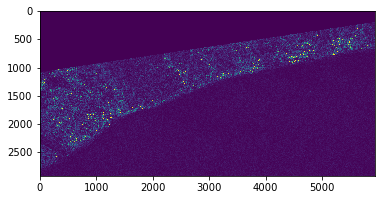

In [22]:
plt.imshow(data0)

## 検討1 : オリジナル画像のままRGBのjpgに変換する
- tiff画像の最大値が65536なので、強引に255に圧縮するのでうまく変換できていないことが分かる
- scale_clipやlogスケール変換など試してみる必要がある

In [30]:
# RGBに変換
data0_rgb = mono_to_color(data0)

In [31]:
# [高さ][幅][色]
data0_rgb.shape

(2914, 5925, 3)

In [32]:
# tiff画像内のスケール差が大きすぎるので0と255が目立つ
data0_rgb

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[255, 255, 255],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[255, 255, 255],
        [ 10,  10,  10],
        [  4,   4,   4],
        ...,
        [  7,   7,   7],
        [ 10,  10,  10],
        [  4,   4,   4]],

       [[255, 255, 255],
        [  3,   3,   3],
        [  7,   7,   7],
        ...,
        [  6,   6,   6],
        [ 10,  10,  10],
        [ 10,  10,  10]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

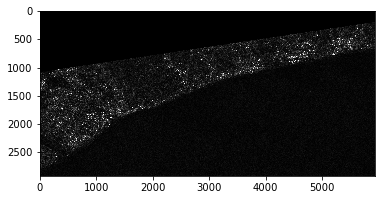

In [33]:
plt.imshow(data0_rgb)

## 検討2 : 画素値を10000までclipした場合

In [27]:
# 画素値を10000でclipする
data0_clip = np.clip(data0, 0, 10000)

In [28]:
data0_clip

array([[10000, 10000, 10000, ..., 10000, 10000, 10000],
       [10000,     0,     0, ...,     0,     0,     0],
       [10000,     0,     0, ...,     0,     0,     0],
       ...,
       [10000,  2654,  1034, ...,  2013,  2694,  1138],
       [10000,  1005,  1915, ...,  1733,  2821,  2821],
       [10000, 10000, 10000, ..., 10000, 10000, 10000]], dtype=uint32)

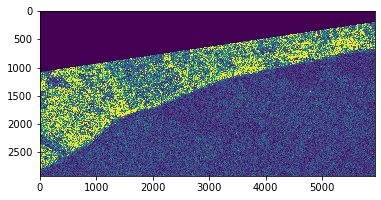

In [29]:
plt.imshow(data0_clip)

In [34]:
# RGBに変換
data0_clip_rgb = mono_to_color(data0_clip)

In [35]:
data0_clip_rgb

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[255, 255, 255],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[255, 255, 255],
        [ 67,  67,  67],
        [ 26,  26,  26],
        ...,
        [ 51,  51,  51],
        [ 68,  68,  68],
        [ 29,  29,  29]],

       [[255, 255, 255],
        [ 25,  25,  25],
        [ 48,  48,  48],
        ...,
        [ 44,  44,  44],
        [ 71,  71,  71],
        [ 71,  71,  71]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

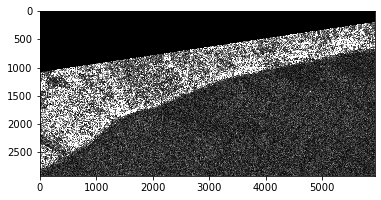

In [36]:
plt.imshow(data0_clip_rgb)

## 検討3 : logスケール化した場合

In [38]:
# data0_logを0以上にする
data0_log = np.log10(data0 + 1.0)

In [39]:
data0_log

array([[4.81648656, 4.81648656, 4.81648656, ..., 4.81648656, 4.81648656,
        4.81648656],
       [4.81648656, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [4.81648656, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [4.81648656, 3.42406453, 3.01494035, ..., 3.30405947, 3.43055877,
        3.05652372],
       [4.81648656, 3.00259798, 3.2823955 , ..., 3.23904909, 3.45055701,
        3.45055701],
       [4.81648656, 4.81648656, 4.81648656, ..., 4.81648656, 4.81648656,
        4.81648656]])

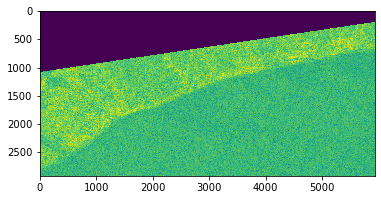

In [40]:
plt.imshow(data0_log)

In [41]:
# RGBに変換
data0_log_rgb = mono_to_color(data0_log)

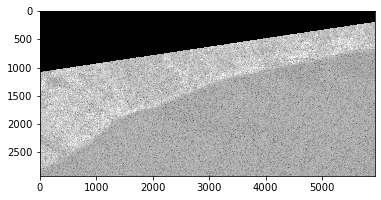

In [42]:
plt.imshow(data0_log_rgb)

## 検討4 : clipしたのち、logスケール化した場合

In [48]:
data0_clip_log = np.log10(data0_clip+1.0)

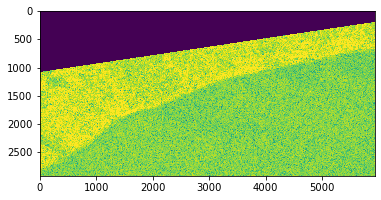

In [49]:
plt.imshow(data0_clip_log)

In [50]:
# RGBに変換
data0_clip_log_rgb = mono_to_color(data0_clip_log)

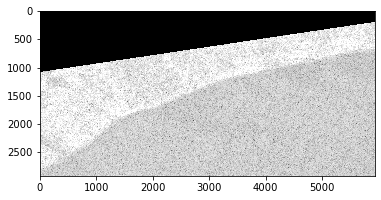

In [51]:
plt.imshow(data0_clip_log_rgb)

# (仮)結論
- 10000でclipしたのち、規格化した画像をtrain画像として利用する

In [52]:
for index, tif_img_path in enumerate(train_tiff_paths):
    img = tifffile.imread(tif_img_path)
    # 画素値で10000までで打ち切る
    img = np.clip(img, 0, 10000)
    # mono_to_color変換
    img = mono_to_color(img)
    # jpg形式で保存(dtype=uint8)
    cv2.imwrite('../arranged_data/train_images/coast_img{:0>2}.jpg'.format(index), img)